## Naive Bayes Model

In this project, I will train a Naive Bayes model on the [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data). The dataset contains 15,000 movie reviews.
### Data

The dataset contains movie reviews from Rotten Tomatoes. Each review is labeled as follows:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In addition to the entire review, the reviews are split into phrases and each phrase is labeled. The entire review is assigned a `SentenceID` and each phrase is assigned a `PhraseID`. The phrases were produced by the Stanford Parser (stanza).

## Section 0: Load the data

In [ ]:
import pandas as pd
import numpy as np

train_url = 'data/nb_train.tsv'
test_url = 'data/nb_test.tsv'

train_df = pd.read_csv(train_url, sep='\t')
test_df = pd.read_csv(test_url, sep='\t')

In [ ]:
## train data
train_df.head(20)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [ ]:
## test data
test_df.head(20)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


## Section 1: Data Exploration



In [ ]:
#Make a dataset with only the full reviews
import seaborn as sns
import matplotlib.pyplot as plt
Full = train_df.groupby('SentenceId', as_index=False).first()
Labels = { 0:'negative', 1 : 'somewhat negative', 2 : 'neutral', 3 : 'somewhat positive', 4 : 'positive'}

In [ ]:
Full

,SentenceId,PhraseId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,64,"This quiet , introspective and entertaining in...",4
2,3,82,"Even fans of Ismail Merchant 's work , I suspe...",1
3,4,117,A positively thrilling combination of ethnogra...,3
4,5,157,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
8524,8540,155985,... either you 're willing to go with this cla...,2
8525,8541,155998,"Despite these annoyances , the capable Claybur...",2
8526,8542,156022,-LRB- Tries -RRB- to parody a genre that 's al...,1
8527,8543,156032,The movie 's downfall is to substitute plot fo...,1


In [ ]:
Valuecounts = Full['Sentiment'].value_counts().to_frame()
Valuecounts['Label'] = Valuecounts.index.map(Labels)
Valuecounts

,Sentiment,Label
3,2321,somewhat positive
1,2200,somewhat negative
2,1655,neutral
4,1281,positive
0,1072,negative


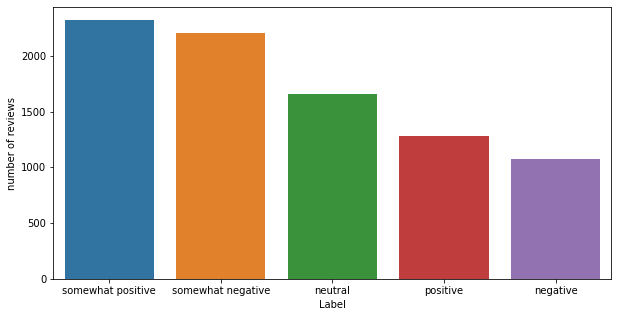

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x =Valuecounts.Label, y = Valuecounts.Sentiment, data = Valuecounts)
plt.ylabel('number of reviews')
plt.show()

## Section 2: Data Preprocessing

In the following section, please preprocess the data. How you preprocess the data will align with what features you are engineering for your model. This might include: tokenization, lemmatization, stemming, removing stopwords, etc. You should also consider how you will handle the labels. You might consider the following: one-hot encoding, label encoding, etc.

In [ ]:
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stemmer = PorterStemmer()
punct = list(string.punctuation) + list(string.digits)
stop_words = stopwords.words('english') + punct
nltk_lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(df):
  #create an empty list to store the processed information
  x_preprocess = []
  #iterate over the dataframe with full labels
  for index, row in df.iterrows():
      text=row['Phrase']

      #tokenize
      tokens = word_tokenize(text)

      nonstop = []
      #remove stopwords and punctuation
      for token in tokens:
            if token in stop_words:
                continue
            else:
                nonstop.append(token)

      #lemmatize
      lemmas = [nltk_lemmatizer.lemmatize(token) for token in nonstop]

      #stemming
      stems =  [stemmer.stem(token) for token in lemmas]

      x_preprocess.append(stems)

  return np.array(x_preprocess)

In [ ]:
x_fullreview = preprocess(Full)


<ipython-input-21-0075f985221f>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_preprocess)


In [ ]:
y_fullreview =Full.Sentiment.values

In [ ]:
x_phrase=preprocess(train_df)

<ipython-input-21-0075f985221f>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_preprocess)


In [ ]:
y_phrase = train_df.Sentiment.values

## Section 3: Feature Engineering

In [ ]:
#tfidf
#grab all the tokens from the original dataset
x_phrases_preprocessed = preprocess(train_df)
train_df['tokens'] = x_phrases_preprocessed

<ipython-input-21-0075f985221f>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_preprocess)


In [ ]:
result = train_df[train_df['tokens'].apply(lambda x: len(x) == 1)]
result['tokens'] = result['tokens'].apply(lambda x: x[0])
term_frequency = (result
                  .groupby(by=['SentenceId', 'tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )

<ipython-input-28-0569202bf47c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['tokens'] = result['tokens'].apply(lambda x: x[0])


In [ ]:
document_frequency = (term_frequency
                      .groupby(['SentenceId', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'})
                     )

In [ ]:
term_frequency = term_frequency.merge(document_frequency)

In [ ]:
term_frequency

,SentenceId,term,term_frequency,document_frequency
0,1,a,1,3.0
1,2984,a,2,3.0
2,5001,a,1,3.0
3,1,adag,2,1.0
4,1,also,2,8.0
...,...,...,...,...
24906,8536,goldi,1,1.0
24907,8537,laughingli,2,1.0
24908,8544,avuncular,1,1.0
24909,8544,chortl,1,1.0


In [ ]:
sentence_in_corpus = term_frequency['SentenceId'].nunique()
term_frequency['idf'] = np.log((1 + sentence_in_corpus) / (1 + term_frequency['document_frequency'])) + 1

In [ ]:
term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']
term_frequency.sort_values(by=['term_frequency'], ascending=False)

,SentenceId,term,term_frequency,document_frequency,idf,tfidf
23132,6209,gotten,8,2.0,8.839394,70.715154
17612,2086,button,7,1.0,9.244859,64.714016
21361,6906,showdown,7,2.0,8.839394,61.875760
13450,839,crowd-pleas,7,2.0,8.839394,61.875760
19113,5516,bomb,7,2.0,8.839394,61.875760
...,...,...,...,...,...,...
9364,4572,obviou,1,11.0,7.453100,7.453100
9363,3374,obviou,1,11.0,7.453100,7.453100
9362,2887,obviou,1,11.0,7.453100,7.453100
9361,2027,obviou,1,11.0,7.453100,7.453100


## Section 4: Model Training

In this section, you should engineer at least two models. You should train each model on the training set and evaluate the performance of each model on the test set. You should also compare the performance of each model. You should also explain the performance of each model.

First I want to see how the model would perform with only the full reviews.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
import math

class NaiveBayesClassifier:
    def __init__(self):
        self.negative_word_counts = {}
        self.somenegative_word_counts = {}
        self.neutral_word_counts = {}
        self.somepositive_word_counts = {}
        self.positive_word_counts = {}

        self.positive_total_count = 0
        self.somepositive_total_count = 0
        self.neutral_total_count = 0
        self.negative_total_count = 0
        self.somenegative_total_count = 0

        self.vocab = set()

    def train(self, data):
        for text, label in data:
            if label == 4:
                self.positive_total_count += 1
                for word in text:
                    self.positive_word_counts[word] = self.positive_word_counts.get(word, 0) + 1
                    self.vocab.add(word)
            elif label ==0:
                self.negative_total_count += 1
                for word in text:
                    self.negative_word_counts[word] = self.negative_word_counts.get(word, 0) + 1
                    self.vocab.add(word)
            elif label ==1:
                self.somenegative_total_count += 1
                for word in text:
                    self.somenegative_word_counts[word] = self.somenegative_word_counts.get(word, 0) + 1
                    self.vocab.add(word)
            elif label ==2:
                self.neutral_total_count += 1
                for word in text:
                    self.neutral_word_counts[word] = self.neutral_word_counts.get(word, 0) + 1
                    self.vocab.add(word)
            elif label == 3:
                self.somepositive_total_count += 1
                for word in text:
                    self.somepositive_word_counts[word] = self.somepositive_word_counts.get(word, 0) + 1
                    self.vocab.add(word)

    def predict(self, text):
        # Calculate the prior probability of each class
        total_count = self.positive_total_count + self.somepositive_total_count +self.neutral_total_count +self.negative_total_count+self.somenegative_total_count
        positive_prior = self.positive_total_count / (total_count + 1e-10)
        negative_prior = self.negative_total_count / (total_count + 1e-10)
        somepositive_prior = self.somepositive_total_count / (total_count + 1e-10)
        somenegative_prior = self.somenegative_total_count / (total_count + 1e-10)
        neutral_prior = self.neutral_total_count / (total_count + 1e-10)

        # Calculate the likelihood of the text given each class
        positive_likelihood = 0
        negative_likelihood = 0
        somepositive_likelihood = 0
        somenegative_likelihood = 0
        neutral_likelihood = 0
        for word in text:
            if word in self.vocab:
                # Add Laplace smoothing to avoid zero probability
                positive_likelihood += math.log((self.positive_word_counts.get(word, 0) + 1) / (self.positive_total_count + len(self.vocab) + 1))
                negative_likelihood += math.log((self.negative_word_counts.get(word, 0) + 1) / (self.negative_total_count + len(self.vocab) + 1))
                somepositive_likelihood += math.log((self.somepositive_word_counts.get(word, 0) + 1) / (self.somepositive_total_count + len(self.vocab) + 1))
                somenegative_likelihood += math.log((self.somenegative_word_counts.get(word, 0) + 1) / (self.somenegative_total_count + len(self.vocab) + 1))
                neutral_likelihood += math.log((self.neutral_word_counts.get(word, 0) + 1) / (self.neutral_total_count + len(self.vocab) + 1))


        positive_posterior = math.exp(positive_likelihood) * positive_prior
        negative_posterior = math.exp(negative_likelihood) * negative_prior
        somepositive_posterior = math.exp(somepositive_likelihood) * somepositive_prior
        somenegative_posterior = math.exp(somenegative_likelihood) * somenegative_prior
        neutral_posterior = math.exp(neutral_likelihood) * neutral_prior

        all = []
        all.extend((negative_posterior,somenegative_posterior,neutral_posterior,somepositive_posterior,positive_posterior))
        maxIndex = all.index(max(all))

        return maxIndex

In [ ]:
nb = NaiveBayesClassifier()
X_train, X_test, y_train, y_test_full = train_test_split(x_fullreview, y_fullreview, test_size=0.2, random_state=42)
nb.train(zip(X_train, y_train))

In [ ]:
correct_predictions = 0
total_predictions = len(X_test)
y_pred_full = []
for text, label in zip(X_test, y_test_full):
    pred = nb.predict(text)
    y_pred_full.append(pred)
    if pred == label:
        correct_predictions += 1
correct_predictions_train = 0
y_pred_full_train = []
total_predictions_train = len(X_train)
for text, label in zip(X_train, y_train):
    pred = nb.predict(text)
    y_pred_full_train.append(pred)
    if pred == label:
        correct_predictions_train += 1

accuracy = correct_predictions / total_predictions
training_accuracy = correct_predictions_train/total_predictions_train
print('The naive bayes model trained on full reviews achieced an validation accuracy of ', accuracy)

The naive bayes model trained on full reviews achieced an validation accuracy of  0.40211019929660025


A different implementation of NaiveBayes:

I will use vectorizd reviews this time with the naive baynes model provided by scikit learn library. My expectation is that vectorization will improve the model performance

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:

vectorizer = CountVectorizer(stop_words='english')
#train_test split
X_train, X_test, y_train, y_test_full = train_test_split(Full.Phrase.values, Full.Sentiment, test_size=0.2, random_state=42)

X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)
nb = MultinomialNB()

nb.fit(X_train_vectors, y_train)
y_train_pred_fullvec = nb.predict(X_train_vectors)
y_pred_fullvec = nb.predict(X_test_vectors)

accuracy_fullvec = accuracy_score(y_test_full, y_pred_fullvec )
accuracy_train_fullvec = accuracy_score(y_train, y_train_pred_fullvec)

print(f'The model trained with vectorized phrase achieve an accuracy with: {accuracy_fullvec:.2f}')

The model trained with vectorized phrase achieve an accuracy with: 0.38


In [ ]:
training_accuracy

0.6107284185842005

In [ ]:
accuracy_train_fullvec

0.8384874688553422

However, the overall accuracy a model trained on vectorized text is lower than previous model. To figure out what happened, I checked the train accuracies for both models. I found that the training accuracy with vectorized text is significanly higher than the testing accuracy with the vectorized text, also it is siginificantly high than the training accuracy with the non-vectorized text. This suggest that with vectorizing the text, the model has overfitting issues. That is why the testing accuracy decrease after applying vectorization.

The I tried to apply a different vectorizer(tfidf vectorizer) instead of count vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

text_clf.fit(X_train, y_train)

y_train_pred_fulltfidf = text_clf.predict(X_train)
y_pred_fulltfidf = text_clf.predict(X_test)

accuracy_fulltfidf = accuracy_score(y_test_full, y_pred_fulltfidf)
accuracy_train_fulltfidf = accuracy_score(y_train, y_train_pred_fulltfidf)

print(f'The model trained with text vectorized by tfidfvectorizer achieve an accuracy with: {accuracy_fulltfidf:.2f}')

The model trained with text vectorized by tfidfvectorizer achieve an accuracy with: 0.39


tfidf vectorizer didn't perform well with the model training.

I also tried to train the model with all the phrases included in the train dataframe.

In [ ]:
nb = NaiveBayesClassifier()
X_train, X_test, y_train, y_test = train_test_split(x_phrase, y_phrase, test_size=0.2, random_state=42)
nb.train(zip(X_train, y_train))

In [ ]:
correct_predictions = 0
total_predictions = len(X_test)
y_pred_phrase=[]
for text, label in zip(X_test, y_test):
    pred = nb.predict(text)
    y_pred_phrase.append(pred)
    if pred == label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print('The naive bayes model trained on phrases achieced an accuracy of ', accuracy)

The naive bayes model trained on phrases achieced an accuracy of  0.5749711649365629


A different implementation of NaiveBayes with vectorization

In [ ]:
#train_test split
X_train, X_test, y_train, y_test = train_test_split(train_df.Phrase.values, y_phrase, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(124848, 31212, 124848, 31212)

In [ ]:
vectorizer = CountVectorizer(stop_words='english')

# Fit the vectorizer on our corpus
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [ ]:
nb = MultinomialNB()

# Fit the classifier on the training data
nb.fit(X_train_vectors, y_train)

# Make predictions on the test data
y_pred_phrase_vec = nb.predict(X_test_vectors)

# Calculate the accuracy of the classifier
accuracy_vec = accuracy_score(y_test, y_pred_phrase_vec)
print(f'The model trained with vectorized phrase achieve an accuracy with: {accuracy_vec:.2f}')

The model trained with vectorized phrase achieve an accuracy with: 0.61


This time count vectorizer helped increase the accuracy score of the model

## Section 5: Model Evaluation

In this section, you should evaluate the performance of your model. You should consider the following: accuracy, precision, recall, f1-score, confusion matrix, classification report, etc.

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

First I looked at the classification report and confusion matrix on the model trained with non-vectorized full reviews

In [ ]:
print(classification_report(y_test_full, y_pred_full, target_names=['negative','somewhat negative', 'neutral','somewhat positive', 'positive']))

                   precision    recall  f1-score   support

         negative       0.56      0.02      0.05       212
somewhat negative       0.42      0.63      0.50       441
          neutral       0.33      0.02      0.04       328
somewhat positive       0.39      0.81      0.52       474
         positive       0.63      0.05      0.09       251

         accuracy                           0.40      1706
        macro avg       0.47      0.31      0.24      1706
     weighted avg       0.44      0.40      0.30      1706



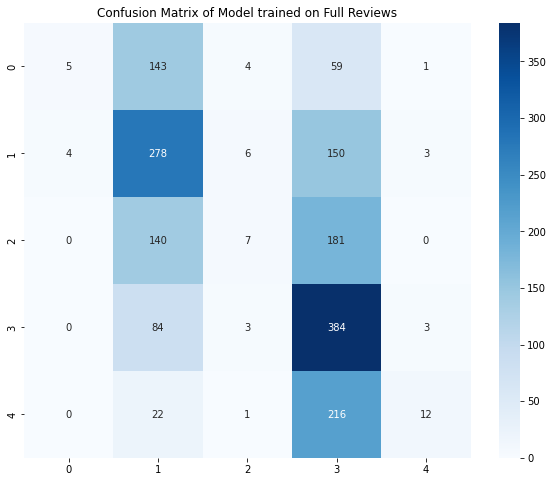

In [ ]:


## visualize the confusion matrix
cfm_full = confusion_matrix(y_test_full, y_pred_full)

## plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cfm_full, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Model trained on Full Reviews')
plt.show()

Then I looked at the classification report and confusion matrix of the model trained with full reviews vectorized with count vectorizer

In [ ]:
print(classification_report(y_test_full, y_pred_fullvec, target_names=['negative','somewhat negative', 'neutral','somewhat positive', 'positive']))

                   precision    recall  f1-score   support

         negative       0.37      0.16      0.22       212
somewhat negative       0.40      0.55      0.46       441
          neutral       0.20      0.09      0.13       328
somewhat positive       0.40      0.57      0.47       474
         positive       0.43      0.30      0.36       251

         accuracy                           0.38      1706
        macro avg       0.36      0.34      0.33      1706
     weighted avg       0.36      0.38      0.35      1706



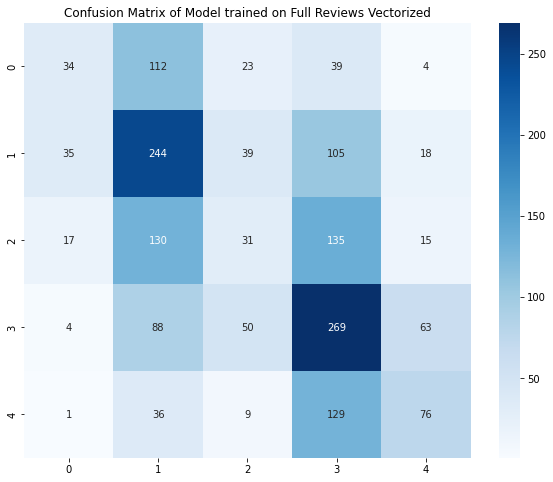

In [ ]:
## visualize the confusion matrix
cfm_fullvec = confusion_matrix(y_test_full, y_pred_fullvec)

## plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cfm_fullvec, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Model trained on Full Reviews Vectorized')
plt.show()

Then I looked at the classification report and confusion matrix of the model trained on all the phrases.

In [ ]:
print(classification_report(y_test, y_pred_phrase, target_names=['negative','somewhat negative', 'neutral','somewhat positive', 'positive']))

                   precision    recall  f1-score   support

         negative       0.55      0.12      0.20      1416
somewhat negative       0.44      0.66      0.53      5527
          neutral       0.79      0.58      0.67     15639
somewhat positive       0.45      0.71      0.55      6707
         positive       0.47      0.11      0.18      1923

         accuracy                           0.57     31212
        macro avg       0.54      0.44      0.43     31212
     weighted avg       0.62      0.57      0.57     31212



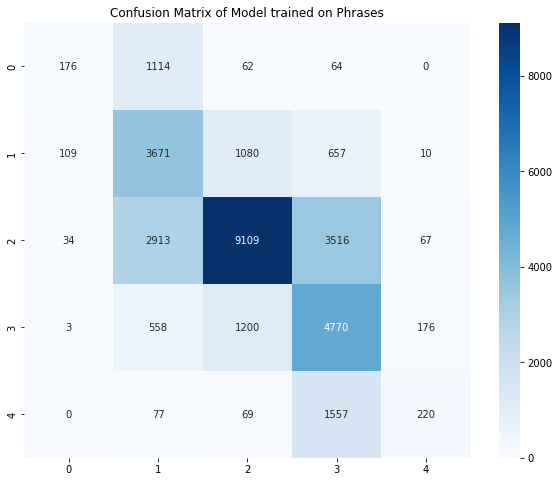

In [ ]:
## visualize the confusion matrix
cfm_phrase= confusion_matrix(y_test, y_pred_phrase)

## plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cfm_phrase, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Model trained on Phrases')
plt.show()

Then I looked at the classification report and confusion matrix of the model trained on vectorized phrases.

In [ ]:
print(classification_report(y_test, y_pred_phrase_vec, target_names=['negative','somewhat negative', 'neutral','somewhat positive', 'positive']))

                   precision    recall  f1-score   support

         negative       0.45      0.28      0.34      1416
somewhat negative       0.50      0.41      0.45      5527
          neutral       0.68      0.80      0.73     15639
somewhat positive       0.52      0.50      0.51      6707
         positive       0.49      0.30      0.37      1923

         accuracy                           0.61     31212
        macro avg       0.53      0.46      0.48     31212
     weighted avg       0.59      0.61      0.60     31212



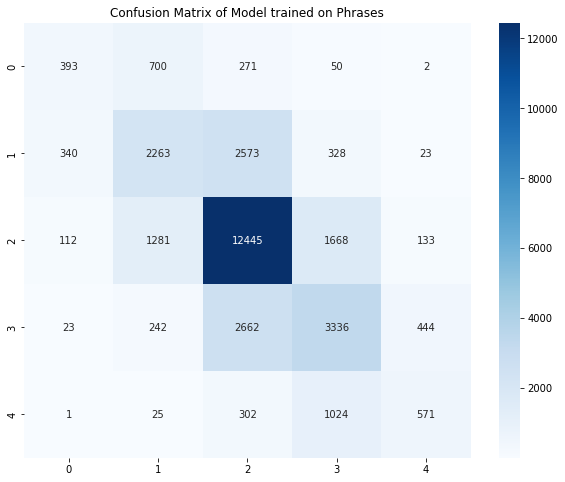

In [ ]:
cfm_phrase_vec= confusion_matrix(y_test,  y_pred_phrase_vec)

## plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cfm_phrase_vec, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Model trained on Phrases')
plt.show()

In [ ]:
## produce some example of test data
## predict with the better model trained on full label

nb = NaiveBayesClassifier()
X_train, X_test, y_train, y_test_full = train_test_split(x_fullreview, y_fullreview, test_size=0.2, random_state=42)
nb.train(zip(X_train, y_train))


In [ ]:
Full_test = test_df.groupby('SentenceId', as_index=False).first()
x_test = Full_test.Phrase.values

In [ ]:
y_test=[]
for text in x_test:
    pred = nb.predict(text)
    y_test.append(pred)


In [ ]:
Full_test['Pred_Sentiment'] = y_test

In [ ]:
Full_test.head(10)

,SentenceId,PhraseId,Phrase,Pred_Sentiment
0,8545,156061,An intermittently pleasing but mostly routine ...,1
1,8546,156076,Kidman is really the only thing that 's worth ...,0
2,8547,156154,Once you get into its rhythm ... the movie bec...,1
3,8548,156178,I kept wishing I was watching a documentary ab...,1
4,8549,156219,"Kinnear does n't aim for our sympathy , but ra...",1
5,8550,156250,"All ends well , sort of , but the frenzied com...",1
6,8551,156272,"It 's a hoot and a half , and a great way for ...",1
7,8552,156324,"The weight of the piece , the unerring profess...",0
8,8553,156362,"The film contains no good jokes , no good scen...",0
9,8554,156405,"An offbeat , sometimes gross and surprisingly ...",1


In [ ]:
sample = Full_test.sample(1)
print(sample.Phrase.values, '\nPrediction: ',sample.Pred_Sentiment.map(Labels))

["It takes a certain kind of horror movie to qualify as ` worse than expected , ' but Ghost Ship somehow manages to do exactly that ."] 
Prediction:  2983    somewhat negative
Name: Pred_Sentiment, dtype: object


This review seems negative to me. Our classfier predict to be somewhat negative. Although it is close, I think it fails to campture certain sarcasm in it.

In [ ]:
sample = Full_test.sample(1)
print(sample.Phrase.values, '\nPrediction: ',sample.Pred_Sentiment.map(Labels))

["The acting is stiff , the story lacks all trace of wit , the sets look like they were borrowed from Gilligan 's Island -- and the CGI Scooby might well be the worst special-effects creation of the year ."] 
Prediction:  610    negative
Name: Pred_Sentiment, dtype: object


This time the algorithm captures negative review correctly.


In [ ]:
Full_test.Pred_Sentiment.value_counts()

1    2535
0     647
2     105
3      23
Name: Pred_Sentiment, dtype: int64

Seems like the model didn't capture any positive review. I then use the model trained on vectorized full reviews. The classification report and confusion matrix indicate that although the overall accuracy score was lower, this model actually captures different labels better than the model trained on non-vectorized data.

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
#train_test split
X_train, X_test, y_train, y_test_full = train_test_split(Full.Phrase.values, Full.Sentiment, test_size=0.2, random_state=42)

X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(x_test)
nb = MultinomialNB()

nb.fit(X_train_vectors, y_train)

MultinomialNB()

In [ ]:
y_test = nb.predict(X_test_vectors)

In [ ]:
Full_test['Pred_Sentiment'] = y_test

In [ ]:
Full_test.head(10)

,SentenceId,PhraseId,Phrase,Pred_Sentiment
0,8545,156061,An intermittently pleasing but mostly routine ...,3
1,8546,156076,Kidman is really the only thing that 's worth ...,3
2,8547,156154,Once you get into its rhythm ... the movie bec...,3
3,8548,156178,I kept wishing I was watching a documentary ab...,1
4,8549,156219,"Kinnear does n't aim for our sympathy , but ra...",4
5,8550,156250,"All ends well , sort of , but the frenzied com...",1
6,8551,156272,"It 's a hoot and a half , and a great way for ...",3
7,8552,156324,"The weight of the piece , the unerring profess...",3
8,8553,156362,"The film contains no good jokes , no good scen...",1
9,8554,156405,"An offbeat , sometimes gross and surprisingly ...",3


In [ ]:
Full_test.Pred_Sentiment.value_counts()

I will sample a few entries and see if the model predict the correct sentiment.

In [ ]:
sample = Full_test.sample(1)
print(sample.Phrase.values, '\nPrediction: ',sample.Pred_Sentiment.map(Labels))

["The creaking , rusty ship makes a fine backdrop , but the ghosts ' haunting is routine ."] 
Prediction:  3297    positive
Name: Pred_Sentiment, dtype: object


I don't think this is predicting correctly. This review sounds like somewhat negative. I am guessing the "fine" in the review make my classfier think that it is a positive review.

I will try to sample another one:

In [ ]:
sample = Full_test.sample(1)
print(sample.Phrase.values, '\nPrediction: ',sample.Pred_Sentiment.map(Labels))

["It 's best to avoid imprisonment with the dull , nerdy folks that inhabit Cherish ."] 
Prediction:  625    neutral
Name: Pred_Sentiment, dtype: object


I think this sentence is negative and my classifier predict it to be neutral.

Let's see how the model I trained on all the phrases perform.

In [ ]:
nb = NaiveBayesClassifier()
X_train, X_test, y_train, y_test = train_test_split(x_phrase, y_phrase, test_size=0.2, random_state=42)
nb.train(zip(X_train, y_train))

In [ ]:
x_test = test_df.Phrase.values

In [ ]:
y_test=[]
for text in x_test:
    pred = nb.predict(text)
    y_test.append(pred)

In [ ]:
test_df['Pred_Sentiment'] = y_test

let's try to see if this model can classfy the reviews that were wrongly classfied in last two models.

In [ ]:
first_match = test_df.loc[test_df['Phrase'].str.contains("The creaking , rusty ship makes a fine backdrop , but the ghosts ' haunting is routine .", na=False)].iloc[0]
print(first_match.Phrase, '\nPrediction: ',Labels[first_match.Pred_Sentiment])

The creaking , rusty ship makes a fine backdrop , but the ghosts ' haunting is routine . 
Prediction:  neutral


This classification is more correct than the previous one. But this classfier obviously tends to classify everythin to be neutral.

In [ ]:
first_match = test_df.loc[test_df['Phrase'].str.contains("It 's best to avoid imprisonment with the dull , nerdy folks that inhabit Cherish .", na=False)].iloc[0]
print(first_match.Phrase, '\nPrediction: ',Labels[first_match.Pred_Sentiment])

It 's best to avoid imprisonment with the dull , nerdy folks that inhabit Cherish . 
Prediction:  neutral


## Section 6: Summary



The naive bayes model trained on full reviews achieced an validation accuracy of  0.40

The model trained with vectorized phrase achieve an accuracy with: 0.38

The model trained with text vectorized by tfidfvectorizer achieve an accuracy with: 0.39

The naive bayes model trained on phrases achieced an accuracy of  0.57

The model trained with vectorized phrase achieve an accuracy with: 0.61




The models I trained with full reviews tend to classify reviews into somewhat negative and somewhat positive. They have a hard time identify neutral, positive and negative reviews. This is probably influenced by the training data containing more somewhat positive and negative labels which is indicated in the first section of this notebook. The model trained with vectorized data is able to recognize more varieties of labels although it scores lower on the overall accuracy. In the confusion matrix, we see that it is able to detect more neutral, positive and negative reviews, although the number is still low. The model I trained with phrases tend to classify things into neutral, because the labels are predominantly neutral. The model I trained with vectorized phrase is better at detecting positive and negative reviews, which is similar to the model I trained with vectorized full reviews.

The strength of Naive Bayes models is that they runs fast, takes little momery space and they are easy to implement.

The assumption of a naive bayes model is the sentiment every word entails is independent of other words in the sentence/text, but it is not the case in reality. Sometimes we find while a individual word in a sentence is positive, the whole sentence entail negative sentiment. Naive Bayes would fail on such sentiment classfication becuase it is looking every word in a sentence independently instead of understanding the sentence as a whole.

I think Naive Bayes is a popular model because it is easy to implement and runs fast. It can still work in many cases when the assumption of independence is true. For example, when I used the naive bayes model on phrases, it achieve higher accuracy because for shorter phrase the assumption of naive bayes model holds true.  